In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
import random
import matplotlib.pyplot as plt


In [6]:

np.random.seed(42)
random.seed(42)
n_samples = 1000
df = pd.read_csv('sredjeni.csv')
X = df.drop(columns=["Cena"])
y = df["Cena"]  

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


def evaluate(model, X_val, y_val, name):
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    log_rmse = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(preds)))
    mape = mean_absolute_percentage_error(y_val, preds)
    metrics = {
        "RMSE": rmse,
        "log-RMSE": log_rmse,
        "MAPE": mape
    }

    # plt.figure(figsize=(6, 4))
    # plt.bar(metrics.keys(), metrics.values(), color=["skyblue", "lightgreen", "salmon"])
    # plt.title(f"Evaluation Metrics - {name}")
    # plt.ylabel("Value")
    # plt.yscale('log')
    # plt.show()
    # print(f"{name} -> RMSE: {rmse:.2f}, log-RMSE: {log_rmse:.4f}, MAPE: {mape:.4f}")
    return metrics



In [7]:
#najobicniji
rf = RandomForestRegressor(n_estimators=200, random_state=42) 
rf.fit(X_train, y_train)
vanilla_rf_metrics = evaluate(rf, X_val, y_val, "Random Forest")

Želimo da vidimo feature importance i da izbacimo ona obilježja čiji je feature importance mali.

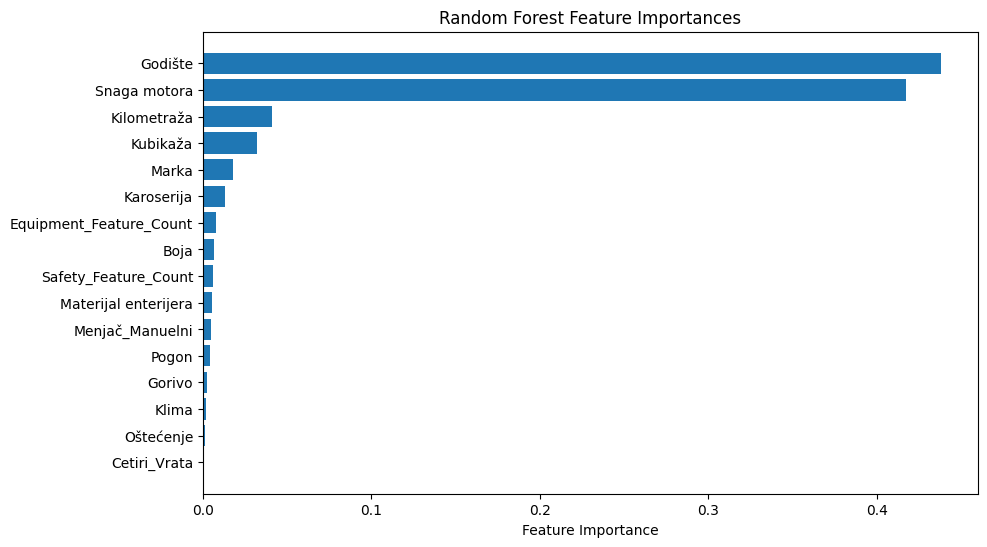

In [8]:

importances = rf.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[sorted_indices], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_indices])
plt.gca().invert_yaxis()  # most important at the top
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

"Cetiri_Vrata", "Gorivo","Klima","Safety_Feature_Count","Materijal enterijera","Boja" su obeležja koja izbacujemo iz skupa

In [37]:
#probavamo da izbacimo parametre koji su slab importance, poboljsanje bude minimalno. Rezultati su sa i bez korekcije slicni
#rezultatima u radovima.
#pokusavamo sa izbacivanjem nekih koji imaju najmanji importance i izbacuju se jedan po jedan. p vrednosti za feature importance.

np.random.seed(42)
n_samples = 1000
df = pd.read_csv('sredjeni.csv')
X_rf = df.drop(columns=["Cena","Cetiri_Vrata", "Gorivo","Klima","Safety_Feature_Count","Materijal enterijera","Boja"])
y_rf = df["Cena"]  

X_train_rf, X_temp_rf, y_train_rf, y_temp_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)
X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(X_temp_rf, y_temp_rf, test_size=0.5, random_state=42)

In [44]:
#najobicniji ali pokrenut nad manje parametara
rf = RandomForestRegressor(n_estimators=200,max_features='log2', random_state=42) 
rf.fit(X_train_rf, y_train_rf)
vanilla_rf_metrics = evaluate(rf, X_val_rf, y_val_rf, "Random Forest")
print(vanilla_rf_metrics)

{'RMSE': np.float64(2501.1255508790805), 'log-RMSE': np.float64(0.2550643370860623), 'MAPE': np.float64(0.20907666659224797)}


Tražimo najbolju kombinaciju hiperparametara pomoću randomized search, s tim da prosljeđujemo skup odataka gdje su izbačena obeležja koja
su imala mali feature importance.

In [42]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_percentage_error', # Use MAPE as the scoring metric
    verbose=2,
    random_state=42,
    n_jobs=-1
)

#unapredjeni rf koji trazi najbolji rezultat sa kombinacijamam parametara. koristimo samo odre]ene parametre -- ovdje smo dobili najbolji rezultat za rf

random_search.fit(X_train_rf, y_train_rf)

best_rf = random_search.best_estimator_
tuned_rf_metrics = evaluate(best_rf, X_val_rf, y_val_rf, "Tuned Random Forest")
print(tuned_rf_metrics)
print(f"Best parameters: {random_search.best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'RMSE': np.float64(2363.602034243249), 'log-RMSE': np.float64(0.25162542132324395), 'MAPE': np.float64(0.20379235809488302)}
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30}


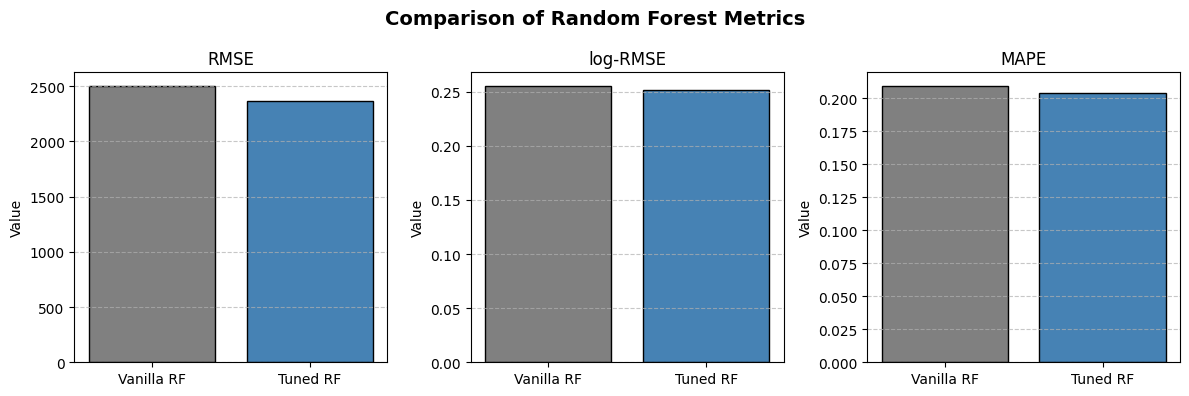

In [45]:
metrics = list(tuned_rf_metrics.keys())
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, metric in enumerate(metrics):
    axes[i].bar(
        ["Vanilla RF", "Tuned RF"],
        [vanilla_rf_metrics[metric], tuned_rf_metrics[metric]],
        color=["gray", "steelblue"],
        edgecolor="black"
    )
    axes[i].set_title(metric)
    axes[i].set_ylabel("Value")
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)

fig.suptitle("Comparison of Random Forest Metrics", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

XGBoost. Prvo smo probali sa najobičnijim. Pa smo kao i za prethodni model, odradili randomized search i prikazali najbolje rezultate.

In [27]:
xgb_model = xgb.XGBRegressor(n_estimators=600, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
vanilla_xgboost_metrics = evaluate(xgb_model, X_val, y_val, "XGBoost")


In [21]:
# optimiyacija  hiperparametara MAPE 0.17
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 2, 3, 4]
}

xgb_model = xgb.XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

best_xgb_model = random_search.best_estimator_

tuned_xgboost_metrics = evaluate(best_xgb_model, X_val, y_val, "Optimized XGBoost")
print(f"Best parameters: {random_search.best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': 0.9, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.7}


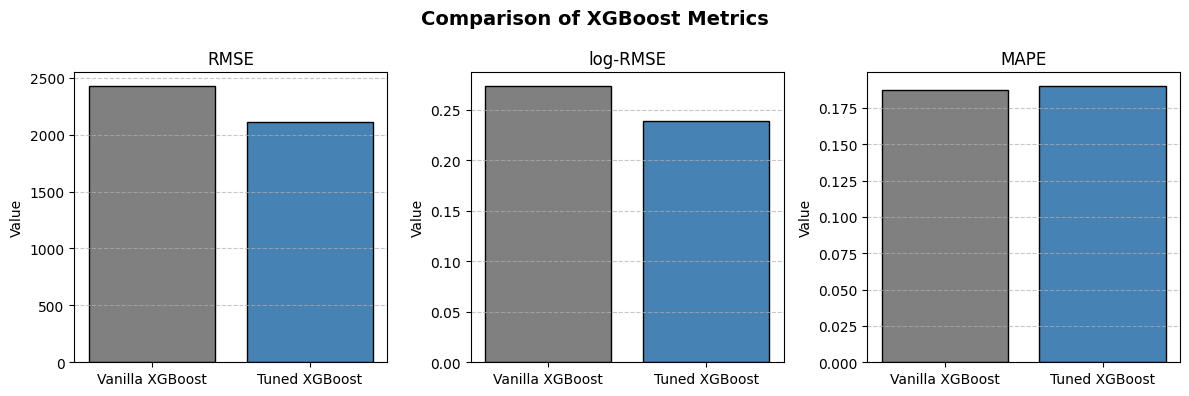

In [28]:
metrics = list(tuned_xgboost_metrics.keys())
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, metric in enumerate(metrics):
    axes[i].bar(
        ["Vanilla XGBoost", "Tuned XGBoost"],
        [vanilla_xgboost_metrics[metric], tuned_xgboost_metrics[metric]],
        color=["gray", "steelblue"],
        edgecolor="black"
    )
    axes[i].set_title(metric)
    axes[i].set_ylabel("Value")
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)

fig.suptitle("Comparison of XGBoost Metrics", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

Forward ANN sa randomized search

In [46]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# arhitektura nase mreze
def build_model(optimizer="adam", learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)
    ])
    if optimizer == "adam":
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        opt = optimizer
    model.compile(optimizer=opt, loss="mse")
    return model

# model wrap za randomized search
keras_reg = KerasRegressor(
    model=build_model, 
    verbose=0,
    random_state=42
)


param_dist = {
    "model__optimizer": ["adam", "sgd"],
    "model__learning_rate": [0.001, 0.01],
    "batch_size": [16, 32, 64],
    "epochs": [50, 100]
}

# 
random_search = RandomizedSearchCV(
    estimator=keras_reg,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    verbose=0,
    n_jobs=1,  # Changed to 1 to avoid multiprocessing issues
    random_state=42,
    scoring="neg_mean_absolute_percentage_error"
)

# FIX: Remove validation_data - not compatible with cross-validation
random_search.fit(X_train, y_train)

# --- Get best model ---
best_ann = random_search.best_estimator_.model_


In [47]:
best_ann_metrics = evaluate(best_ann, X_val, y_val, "Tuned ANN")
print("\nBest parameters:", random_search.best_params_)
print("Best CV score:", -random_search.best_score_)  # Negative because sklearn uses negative MAPE

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Best parameters: {'model__optimizer': 'adam', 'model__learning_rate': 0.01, 'epochs': 50, 'batch_size': 64}
Best CV score: 0.242408158420362


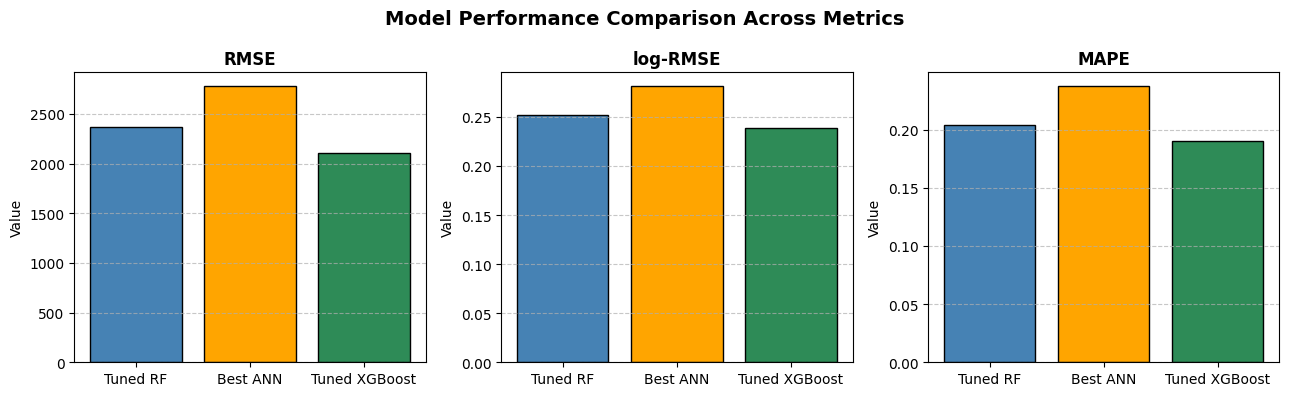

In [48]:
metrics = list(tuned_rf_metrics.keys())
models = ["Tuned RF", "Best ANN", "Tuned XGBoost"]
colors = ["steelblue", "orange", "seagreen"]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

for i, metric in enumerate(metrics):
    values = [
        tuned_rf_metrics[metric],
        best_ann_metrics[metric],
        tuned_xgboost_metrics[metric]
    ]
    axes[i].bar(models, values, color=colors, edgecolor="black")
    axes[i].set_title(metric, fontsize=12, fontweight="bold")
    axes[i].set_ylabel("Value")
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)

fig.suptitle("Model Performance Comparison Across Metrics", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

Iz pokazanih rezultata, vidimo da je ANN imala značajno daje slabiji rezultat od druga dva algoritma mašinskog učenja, jer je za njegovo treniranje potrebno 
više od naših 3k podataka

Sumirani rezultati - tabelarni prikaz

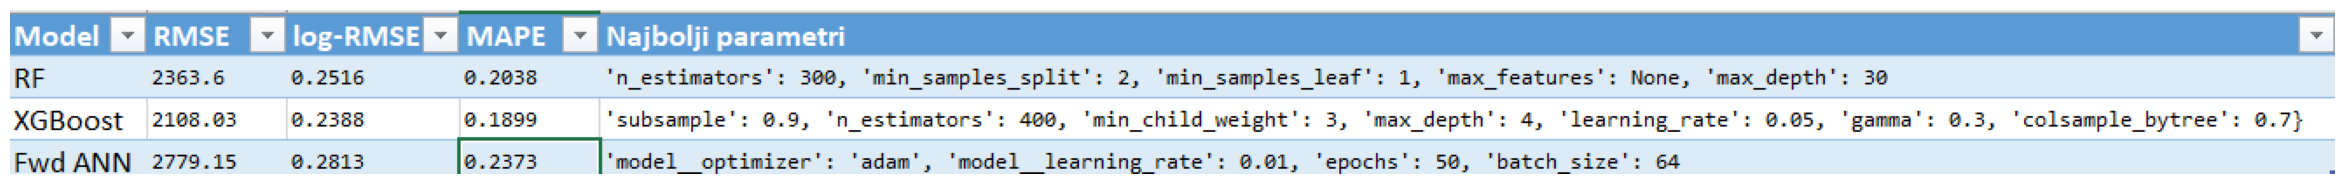

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("C:/Users/Laptop/Pictures/Screenshots/Screenshot 2025-09-29 220244.png")
plt.figure(figsize=(30, 15)) 
plt.imshow(img)
plt.axis("off")  # optional: hide axes
plt.show()